# PREPARING DATASETS

In [36]:
#DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [1]:
#DATA SOURCES:
foreign_workers_url = 'https://statdb.mol.gov.tw/html/mon/i0120020620e.htm'
foreign_students_url = 'https://data.gov.tw/en/datasets/42158?utm_source=chatgpt.com'
unemployement_url = 'https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?k=engmain'

# CLEANING THE DATASETS

In [ ]:
workers_file_path = "c12010.csv"
data = pd.read_csv(workers_file_path, skip_blank_lines=True, header=None)

filtered_data = data[data[0].str.contains("End of", na=False)]

def extract_year_and_total(row):
    match = re.match(r"(End of \d{4})\s+([\d,]+)", row)
    if match:
        year = match.group(1).replace("End of ", "")
        total = match.group(2).replace(",", "")
        return year, int(total)
    return None, None

extracted_data = filtered_data[0].apply(extract_year_and_total)
cleaned_data = pd.DataFrame(extracted_data.tolist(), columns=["Year", "Grand Total"])
cleaned_data.dropna(inplace=True)

cleaned_data = cleaned_data[cleaned_data["Grand Total"] > 500000]

cleaned_data.reset_index(drop=True, inplace=True)

cleaned_data.to_csv("cleaned_foreign_workers_data.csv", index=False)


In [ ]:
students_file_path = "各學年度大專校院境外學生在臺留學研習人數統計.csv"
foreign_students_data = pd.read_csv(students_file_path)

relevant_students = foreign_students_data[
    foreign_students_data["學生類型"].isin(["正式修讀學位外國生", "僑生（含港澳）", "正式修讀學位陸生", "外國交換生"])
]

column_mapping = {
    "學生類型": "Student Type",
    "99學年度": 2010,
    "100學年度": 2011,
    "101學年度": 2012,
    "102學年度": 2013,
    "103學年度": 2014,
    "104學年度": 2015,
    "105學年度": 2016,
    "106學年度": 2017,
    "107學年度": 2018,
    "108學年度": 2019,
    "109學年度": 2020,
    "110學年度": 2021,
    "111學年度": 2022,
    "112學年度": 2023,
}
relevant_students.rename(columns=column_mapping, inplace=True)

filtered_data = relevant_students[
    ["Student Type", 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
]

filtered_data.iloc[:, 1:] = filtered_data.iloc[:, 1:].replace(",", "", regex=True).astype(int)

filtered_data.loc["Grand Total"] = filtered_data.iloc[:, 1:].sum()
filtered_data.reset_index(drop=True, inplace=True)

filtered_data.to_csv("cleaned_foreign_students_data.csv", index=False)


In [ ]:
file_path = "E040111010-05759657.csv"
unemployment_data = pd.read_csv(file_path, encoding='utf-8-sig', header=2) 

unemployment_data = unemployment_data[['Period', 'Total', 'Annual Growth Rate(%)']]

unemployment_data = unemployment_data[unemployment_data['Period'].apply(lambda x: str(x).isdigit())]

unemployment_data['Period'] = unemployment_data['Period'].astype(int)  
unemployment_data['Total'] = unemployment_data['Total'].astype(float) 
unemployment_data['Annual Growth Rate(%)'] = unemployment_data['Annual Growth Rate(%)'].astype(float)  

filtered_unemployment_data = unemployment_data[
    (unemployment_data['Period'] >= 2015) & (unemployment_data['Period'] <= 2023)
]

filtered_unemployment_data.reset_index(drop=True, inplace=True)

output_path = "cleaned_unemployment_data_2015_2023.csv"
filtered_unemployment_data.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to {output_path}")

# PREPROCESSING DATASETS

In [5]:
# Loading our cleaned datasets
foreign_workers_df = pd.read_csv('cleaned_foreign_workers_data.csv')
foreign_students_df = pd.read_csv('cleaned_foreign_students_data.csv')
unemployment_df = pd.read_csv('cleaned_unemployment_data.csv')

#check
print("Foreign Workers DataFrame Info:")
print(foreign_workers_df.info())
print(foreign_workers_df.head())

print("\nForeign Students DataFrame Info:")
print(foreign_students_df.info())
print(foreign_students_df.head())

print("\nUnemployment DataFrame Info:")
print(unemployment_df.info())
print(unemployment_df.head())

Foreign Workers DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         10 non-null     object 
 1   Grand Total  10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 292.0+ bytes
None
   Year  Grand Total
0  2015     587940.0
1  2016     624768.0
2  2017     676142.0
3  2018     706850.0
4  2019     718058.0

Foreign Students DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Student Type  4 non-null      object
 1   2015          5 non-null      int64 
 2   2016          5 non-null      int64 
 3   2017          5 non-null      int64 
 4   2018          5 non-null      int64 
 5   2019          5 non-null      int64 
 6   2020          5 non-null      int64

In [32]:
foreign_workers_df.rename(columns={'Grand Total': 'foreign_workers'}, inplace=True)
foreign_workers_df['Year'] = pd.to_numeric(foreign_workers_df['Year'], errors='coerce')
foreign_workers_df.dropna(subset=['Year'], inplace=True)
foreign_workers_df['Year'] = foreign_workers_df['Year'].astype(int)
foreign_workers_df = foreign_workers_df[foreign_workers_df['Year'] <= 2023]

mask_total = foreign_students_df['Student Type'].isna()
foreign_students_total = foreign_students_df[mask_total].copy()
year_cols = [str(y) for y in range(2015, 2024)]
foreign_students_long = foreign_students_total.melt(
    id_vars=['Student Type'],
    value_vars=year_cols,
    var_name='Year',
    value_name='foreign_students'
)
foreign_students_long['Year'] = pd.to_numeric(foreign_students_long['Year'], errors='coerce')
foreign_students_long.drop(columns='Student Type', inplace=True)

unemployment_df.rename(columns={'Period': 'Year', 'Total': 'unemployment_total'}, inplace=True)
unemployment_df = unemployment_df[['Year', 'unemployment_total']]
unemployment_df['Year'] = pd.to_numeric(unemployment_df['Year'], errors='coerce')
unemployment_df.dropna(subset=['Year'], inplace=True)
unemployment_df['Year'] = unemployment_df['Year'].astype(int)
unemployment_df = unemployment_df[unemployment_df['Year'] <= 2023]

merged_df = pd.merge(foreign_workers_df, foreign_students_long, on='Year', how='inner')
merged_df = pd.merge(merged_df, unemployment_df, on='Year', how='inner')

merged_df.dropna(inplace=True)
merged_df.sort_values('Year', inplace=True)

print("Merged DataFrame (head):")
print(merged_df.head(), "\n")
print("Merged DataFrame shape:", merged_df.shape, "\n")
print("Merged DataFrame years:", merged_df['Year'].tolist(), "\n")

Merged DataFrame (head):
   Year  foreign_workers  foreign_students  unemployment_total
0  2015         587940.0             50596               440.0
1  2016         624768.0             56042               460.0
2  2017         676142.0             60772               443.0
3  2018         706850.0             67212               440.0
4  2019         718058.0             69296               446.0 

Merged DataFrame shape: (9, 4) 

Merged DataFrame years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023] 



# DATA VISUALIZATION AND ANALYSIS

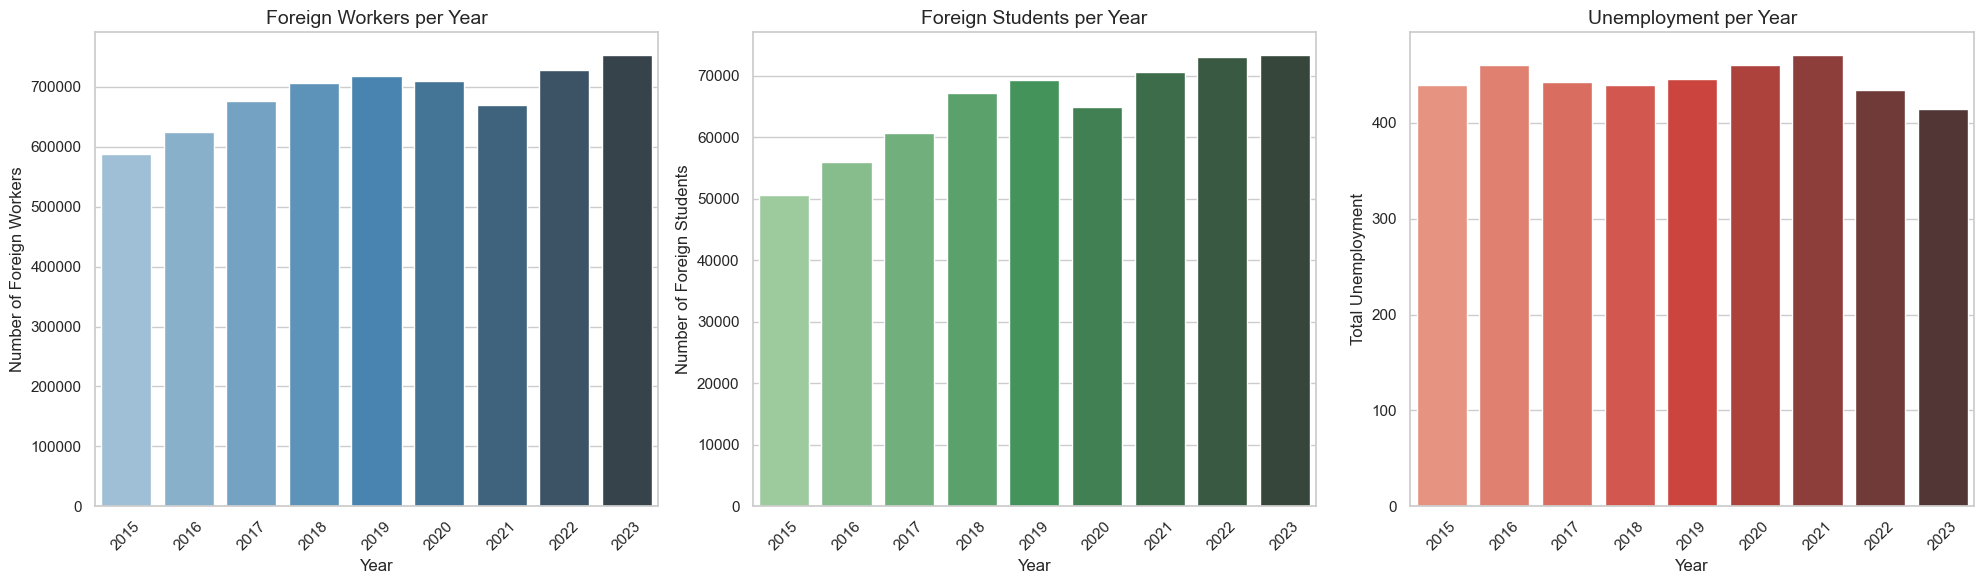

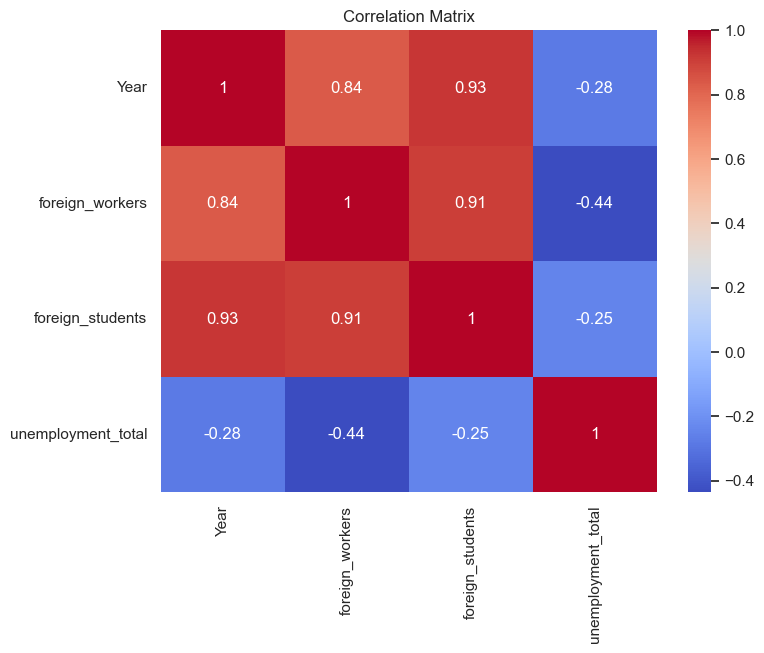

C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


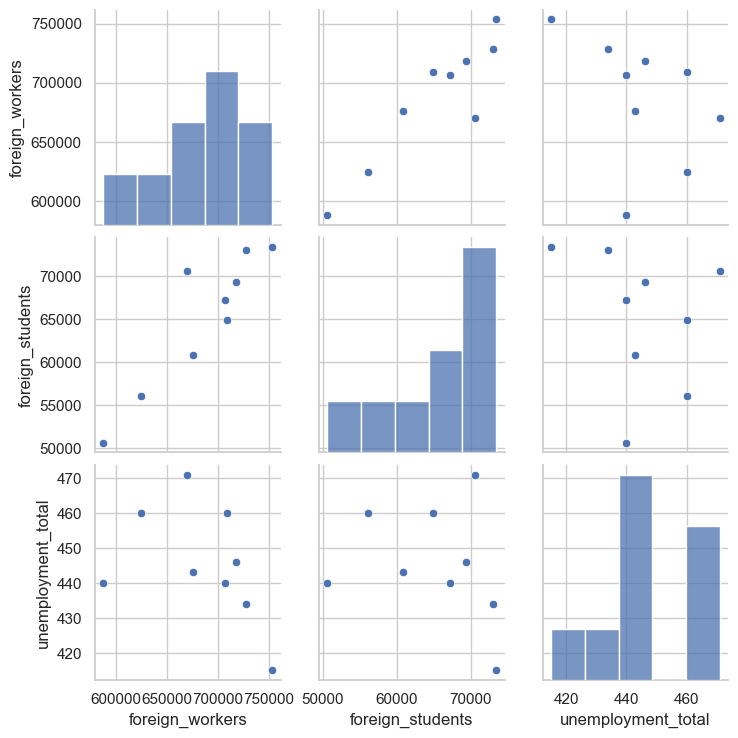

In [49]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(x='Year', y='foreign_workers', data=merged_df, ax=axes[0], palette='Blues_d')
axes[0].set_title('Foreign Workers per Year', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Number of Foreign Workers', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Year', y='foreign_students', data=merged_df, ax=axes[1], palette='Greens_d')
axes[1].set_title('Foreign Students per Year', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Foreign Students', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Year', y='unemployment_total', data=merged_df, ax=axes[2], palette='Reds_d')
axes[2].set_title('Unemployment per Year', fontsize=14)
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('Total Unemployment', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

sns.pairplot(merged_df, vars=[
     'foreign_workers', 'foreign_students', 'unemployment_total'
 ])
plt.show()

# TRAINNING PREPARATION AND FEATURE ENGINEERING

In [39]:
features = ['foreign_workers', 'foreign_students']
X = merged_df[features]
y = merged_df['unemployment_total']

tscv = TimeSeriesSplit(n_splits=3)

param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_dist_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 1.0]
}

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

param_dist_lgb = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [2, 4, 8],
    'learning_rate': [0.001, 0.01, 0.1],
    'min_data_in_leaf': [1, 2, 5],
    'subsample': [0.6, 1.0]
}

param_dist_cb = {
    'iterations': [50, 100, 200],
    'depth': [2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 1.0]
}
def tune_model_ts(model, param_dist, model_name):
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=5,   
        cv=tscv,     
        scoring='r2',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    print(f"\n=== Tuning {model_name} (TimeSeriesSplit) ===")
    rs.fit(X, y)
    print(f"\nBest Params for {model_name}:", rs.best_params_)
    print(f"Best CV R^2 for {model_name}: {rs.best_score_:.3f}")
    return rs.best_estimator_, rs.best_score_

# MODEL TRAINING AND EVALUATION

In [41]:
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42, verbosity=0)
lgb_model = LGBMRegressor(random_state=42)
cb_model = CatBoostRegressor(random_state=42, verbose=0)

models_info = [
    (rf_model, param_dist_rf, "RandomForest"),
    (gb_model, param_dist_gb, "GradientBoosting"),
    (xgb_model, param_dist_xgb, "XGBoost"),
    (lgb_model, param_dist_lgb, "LightGBM"),
    (cb_model, param_dist_cb, "CatBoost")
]

best_models = {}
cv_scores = {}

for model, param_dist, name in models_info:
    best_est, best_score = tune_model_ts(model, param_dist, name)
    best_models[name] = best_est
    cv_scores[name] = best_score

print("\n=== Cross-Validation R^2 Scores (TimeSeriesSplit) ===")
for name in best_models:
    print(f"{name}: {cv_scores[name]:.3f}")

all_years = merged_df['Year'].unique()
max_year = all_years.max()
print(f"\nAll years in dataset: {all_years}, holding out {max_year} as final test.\n")

train_df = merged_df[merged_df['Year'] < max_year]
test_df = merged_df[merged_df['Year'] == max_year]

X_train_final = train_df[features]
y_train_final = train_df['unemployment_total']
X_test_final = test_df[features]
y_test_final = test_df['unemployment_total']

print("Train years:", train_df['Year'].unique())
print("Test year:", test_df['Year'].unique(), "\n")


=== Tuning RandomForest (TimeSeriesSplit) ===
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Params for RandomForest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best CV R^2 for RandomForest: -8.343

=== Tuning GradientBoosting (TimeSeriesSplit) ===
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Params for GradientBoosting: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.001}
Best CV R^2 for GradientBoosting: -7.866

=== Tuning XGBoost (TimeSeriesSplit) ===
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Params for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.001}
Best CV R^2 for XGBoost: -7.744

=== Tuning LightGBM (TimeSeriesSplit) ===
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGB

C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [45]:
hold_out_results = []

for name, model in best_models.items():
    model.fit(X_train_final, y_train_final)
    y_pred_ho = model.predict(X_test_final)
    
    mae_ho = mean_absolute_error(y_test_final, y_pred_ho)
    mse_ho = mean_squared_error(y_test_final, y_pred_ho)
    rmse_ho = np.sqrt(mse_ho)
    r2_ho = r2_score(y_test_final, y_pred_ho)
    
    hold_out_results.append({
        'Model': name,
        'MAE': mae_ho,
        'MSE': mse_ho,
        'RMSE': rmse_ho,
        'R^2': r2_ho
    })
    
hold_out_df = pd.DataFrame(hold_out_results)
print("=== Hold-Out Test Set (Final Year) Performance ===")
print(hold_out_df.sort_values(by='R^2', ascending=False))

comparison_df = hold_out_df.copy()
comparison_df['CV_R^2'] = comparison_df['Model'].map(cv_scores)  # add the cross-val R^2 column
print("\n=== Combined CV and Hold-Out Comparison ===")
print(comparison_df[['Model','CV_R^2','R^2','MAE','MSE','RMSE']].sort_values(by='R^2', ascending=False))

# DONE

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 2
[LightGBM] [Info] Start training from score 449.250000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with les

# SCENARIO PREDICTIONS

In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2  = r2_score(y, y_pred)
print("Trained Model Performance on Historical Data:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R^2: {r2:.2f}")

last_year = memodel = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2  = r2_score(y, y_pred)
print("\n=== Model Performance on Historical Data ===")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {np.sqrt(mse):.2f}, R^2: {r2:.2f}")

scenarios = {
    "A_increase_students":  {"fw_growth": 0.00,  "fs_growth": 0.10},
    "B_increase_workers":   {"fw_growth": 0.10,  "fs_growth": 0.00},
    "C_increase_both":      {"fw_growth": 0.10,  "fs_growth": 0.10},
    "D_increase_stud_decr_work": {"fw_growth": -0.05, "fs_growth": 0.10},
    "E_increase_work_decr_stud": {"fw_growth": 0.10,  "fs_growth": -0.05},
    "F_decrease_students":  {"fw_growth": 0.00,  "fs_growth": -0.05},
    "G_decrease_workers":   {"fw_growth": -0.05, "fs_growth": 0.00}
}

future_years = [2024, 2025, 2026]

last_year = merged_df["Year"].max()
last_workers = merged_df.loc[merged_df["Year"] == last_year, "foreign_workers"].values[0]
last_students = merged_df.loc[merged_df["Year"] == last_year, "foreign_students"].values[0]

scenario_results = {}

for scenario_name, growth_dict in scenarios.items():
    fw_growth = growth_dict["fw_growth"]
    fs_growth = growth_dict["fs_growth"]
    
    curr_workers = last_workers
    curr_students = last_students
    
    future_data = []
    
    for yr in future_years:
        curr_workers   = curr_workers   * (1 + fw_growth)
        curr_students  = curr_students  * (1 + fs_growth)
        
        future_data.append({
            "Year": yr,
            "foreign_workers": curr_workers,
            "foreign_students": curr_students
        })

    df_future = pd.DataFrame(future_data)
    
    X_future = df_future[["foreign_workers", "foreign_students"]]
    preds = model.predict(X_future)
    df_future["predicted_unemployment"] = preds
    
    scenario_results[scenario_name] = df_future

for scenario_name, df_future in scenario_results.items():
    print(f"\n=== Scenario: {scenario_name} ===")
    print(df_future)
    avg_pred = df_future["predicted_unemployment"].mean()
    print(f"Average Predicted Unemployment (2024–2026): {avg_pred:.2f}")

print("\n=== SCENARIO-BASED ANALYSIS COMPLETE ===")
print("Compare the predicted_unemployment columns across scenarios to see")
print("which factor (foreign workers vs. students) has a larger effect on unemployment.\n")

Trained Model Performance on Historical Data:
MAE: 5.71, MSE: 38.51, R^2: 0.84

=== Model Performance on Historical Data ===
MAE: 5.71, MSE: 38.51, RMSE: 6.21, R^2: 0.84

=== Scenario: A_increase_students ===
   Year  foreign_workers  foreign_students  predicted_unemployment
0  2024         753430.0         80738.900                  422.65
1  2025         753430.0         88812.790                  422.65
2  2026         753430.0         97694.069                  422.65
Average Predicted Unemployment (2024–2026): 422.65

=== Scenario: B_increase_workers ===
   Year  foreign_workers  foreign_students  predicted_unemployment
0  2024        828773.00           73399.0                  422.65
1  2025        911650.30           73399.0                  422.65
2  2026       1002815.33           73399.0                  422.65
Average Predicted Unemployment (2024–2026): 422.65

=== Scenario: C_increase_both ===
   Year  foreign_workers  foreign_students  predicted_unemployment
0  2024      